In [2]:
from IPython.display import display, Image
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, MonthLocator

In [3]:
data = pd.read_pickle(r"./data/B00020S.pkl")
data['Date'] = pd.to_datetime(data['Date'])
data['B00020S'] = data['B00020S'].str.replace(',', '.').astype(float)

0


In [8]:
round(data['B00020S'].isnull().sum()/len(data), 2)

0.44

# Estymacja poziomu wody w Odrze na wysokości Głogowa

## Mapa przedstawiająca stacje hydrologiczne na Odrze i jej dopływach.

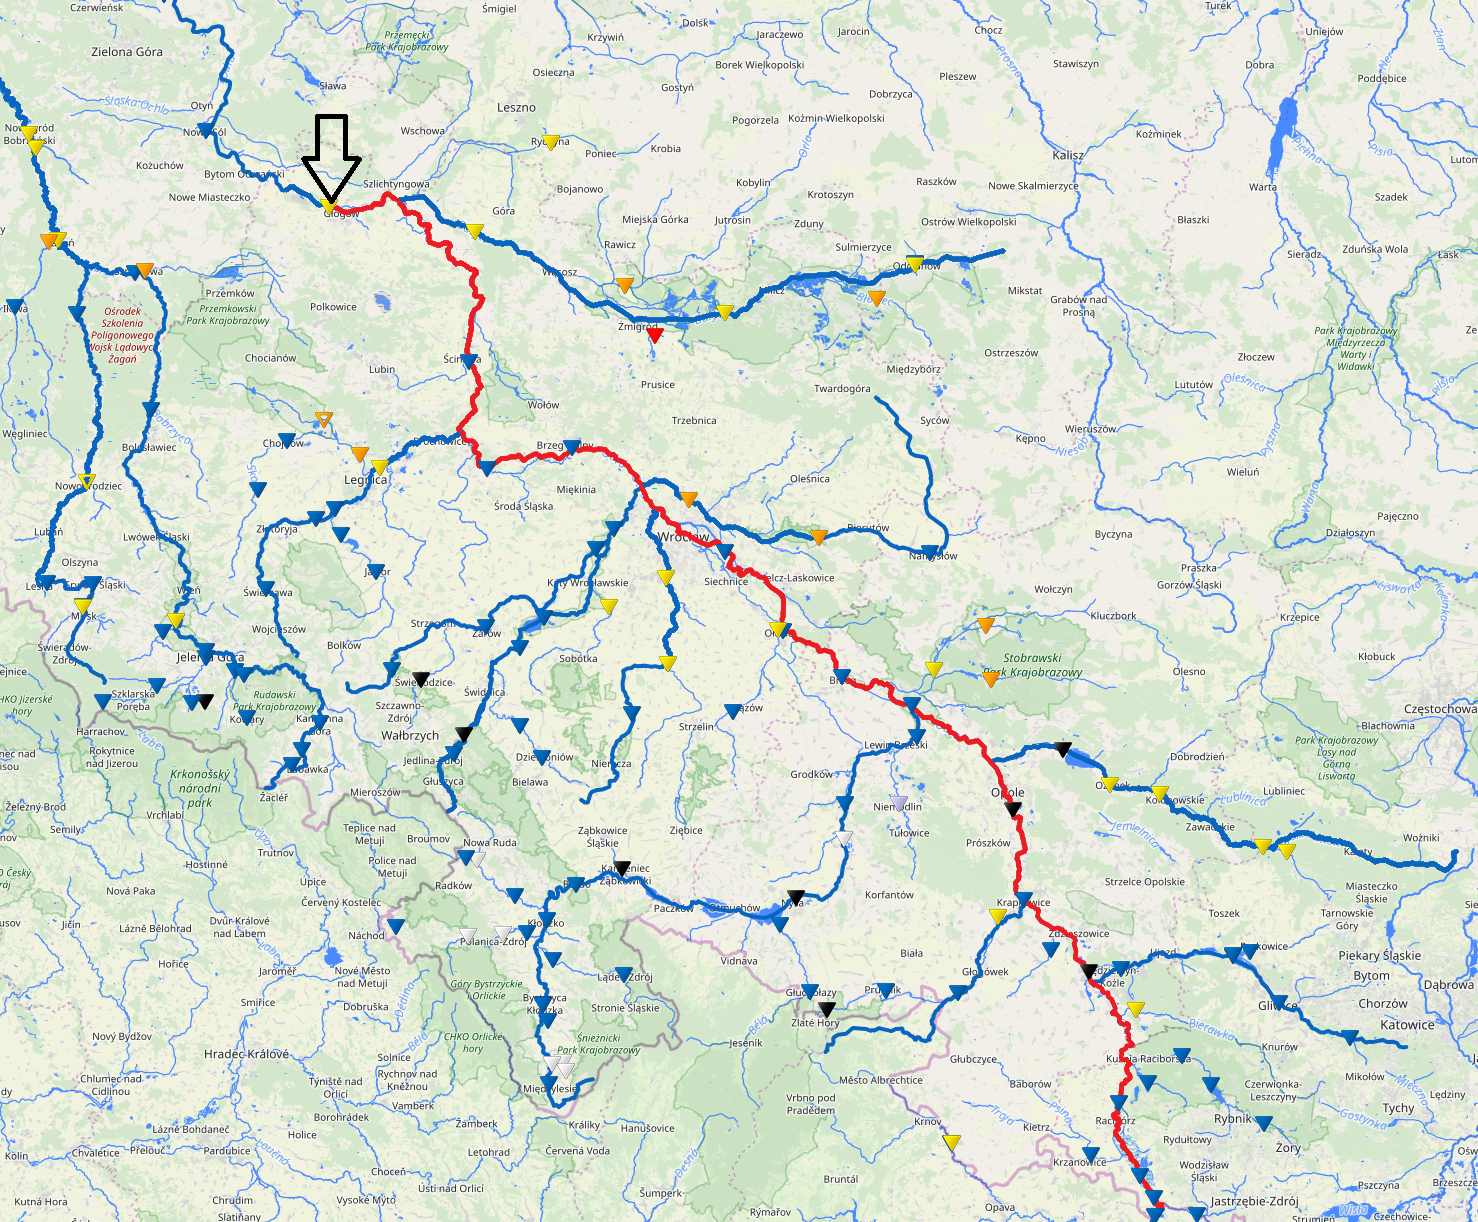

In [2]:
display(Image(filename='./data/imgw-map.png'))

## Wykres porównujący poziom wody w wybranych stacjach

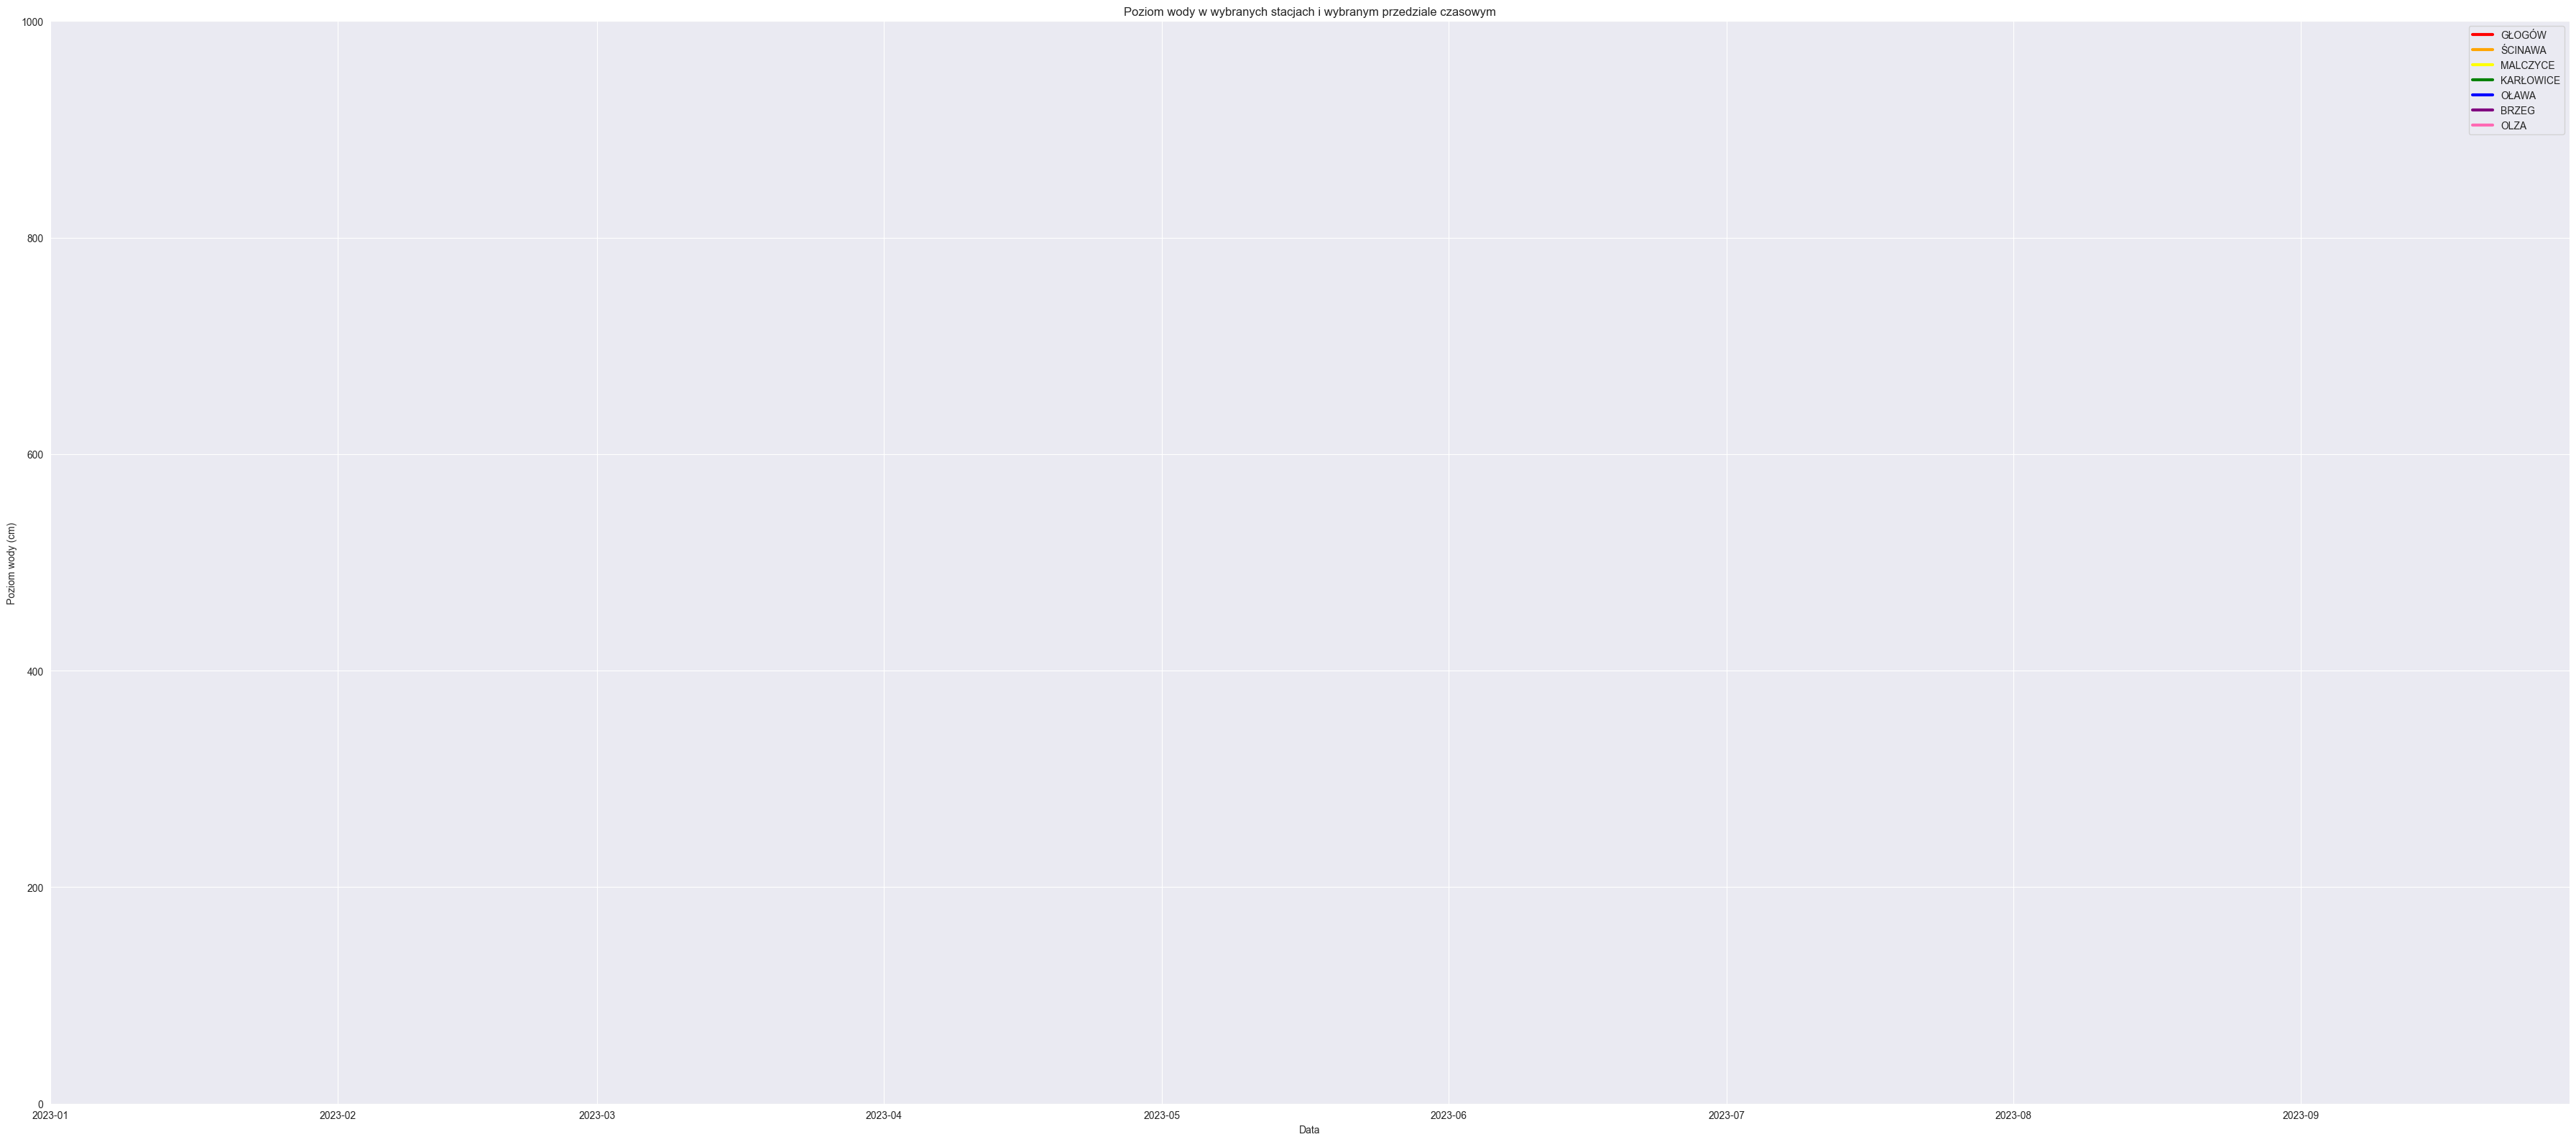

In [104]:
stations = ['GŁOGÓW', 'ŚCINAWA', 'MALCZYCE', 'KARŁOWICE', 'OŁAWA', 'BRZEG', 'OLZA']
years = [2023] # 2008 - dziwne peaki w Ścinawie,
               # 2009 - dziwne peaki w Ścinawie,
               # 2014 - dobry do pokazania anomalii z Głogowem,
               # 2015 - zaczynają się luki w danych,
               # 2018 - nie ma praktycznie żadnych danych,
               # 2019 - nie ma żadnych danych
               # 2020 - nie ma żadnych danych
               # 2021 - nie ma żadnych danych
               # 2022 - nie ma żadnych danych z wyjątkiem małego okresu
               # 2023 - nie ma żadnych danych
months = range(1,13)
custom_palette = [(1.0, 0.0, 0.0), (1.0, 0.647, 0.0), (1.0, 1.0, 0.0), (0.0, 0.502, 0.0), (0.0, 0.0, 1.0), (0.502, 0.0, 0.502),  (1.0, 0.412, 0.706)]

fig, ax = plt.subplots(figsize=(36,16))

data_temp = data.groupby(['Date', 'Station'])['B00020S'].mean().reset_index()

data_temp = data_temp[(data_temp['Date'].dt.year.isin(years)) & (data_temp['Date'].dt.month.isin(months))]

# Dla 'GŁOGÓW' użyj koloru czerwonego
# data_station_glogow = data_temp[data_temp['Station'] == 'GŁOGÓW']
# ax.plot(data_station_glogow['Date'], data_station_glogow['B00020S']-90, label='GŁOGÓW', linewidth=2, color='red') # DLACZEGO -90 ?????

for i, station in enumerate(stations):
    data_station = data_temp[data_temp['Station'] == station]
    color = custom_palette[i]
    ax.plot(data_station['Date'], data_station['B00020S'], label=station, linewidth=3, color=color)

ax.legend()

ax.set_xlabel('Data')
ax.set_ylabel('Poziom wody (cm)')
ax.set_title('Poziom wody w wybranych stacjach i wybranym przedziale czasowym')

plt.tight_layout()

plt.xlim(data_temp['Date'].min(), data_temp['Date'].max())
plt.ylim(0, 1000)

plt.show()

## Wykres porównujący poziom wody w Głogowie w wybranych latach

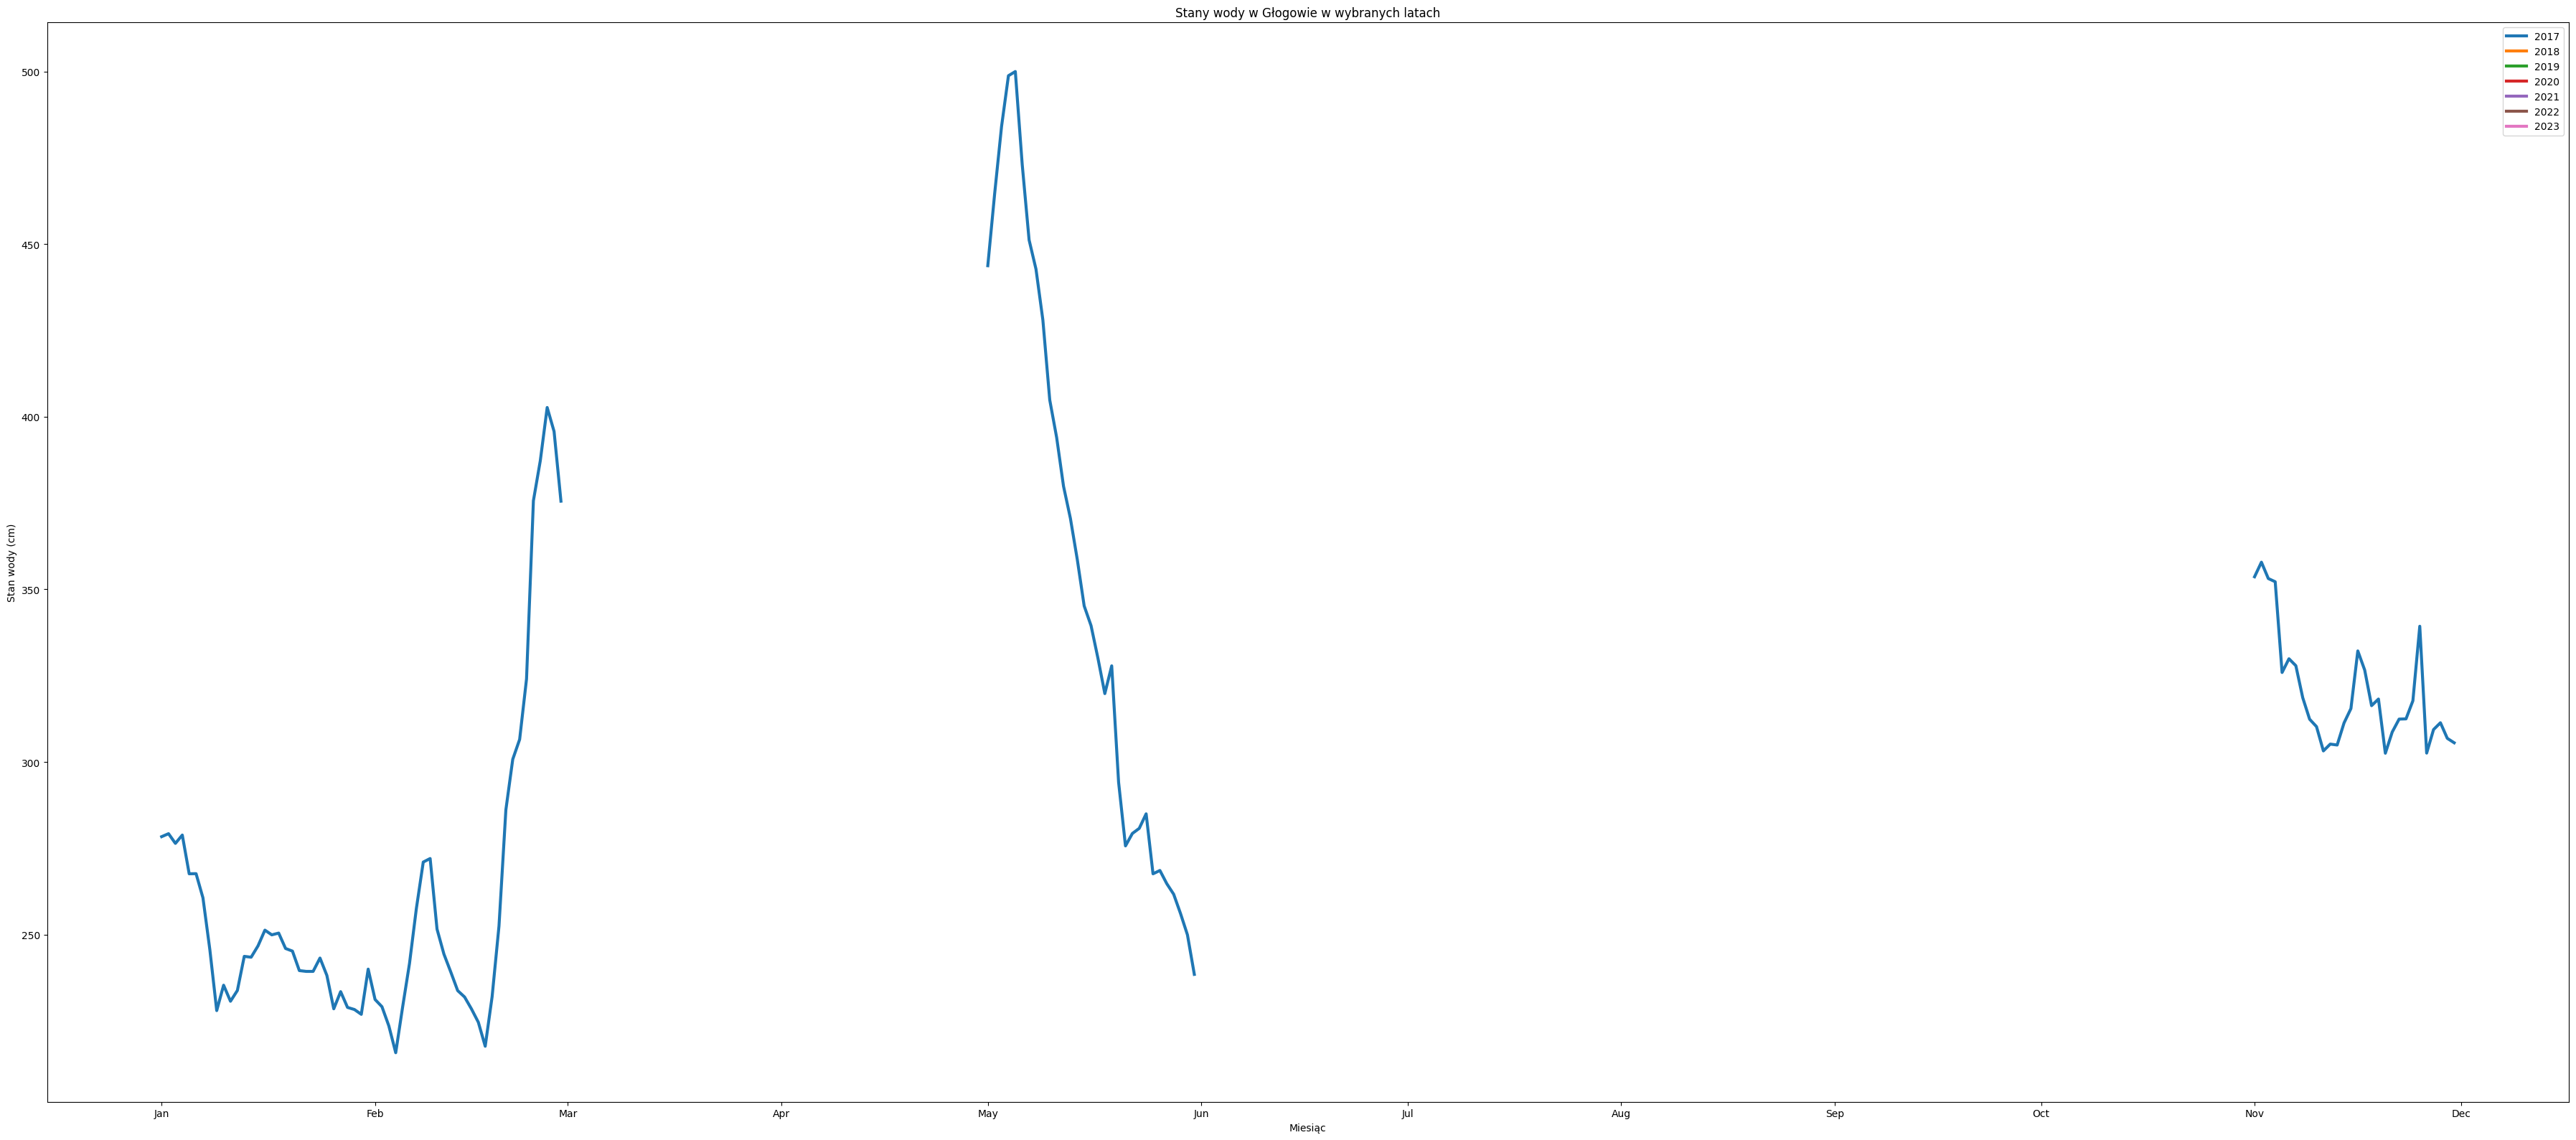

In [13]:
years = range(2017, 2024) # od 2015 do 2017 zaczynają się luki w danych
station_name = 'GŁOGÓW'
parameter_code = 'B00020S'

data_glg = data[data.Station == station_name]
data_grouped = data_glg.groupby(['Date'])[parameter_code].mean().reset_index()
data_grouped['Year'] = data_grouped['Date'].dt.year
data_grouped['Date'] = data_grouped['Date'].dt.strftime('%m-%d')

fig, ax = plt.subplots(figsize=(36, 16))

for i, year in enumerate(years):
    data_year = data_grouped[data_grouped['Year'] == year]
    ax.plot(data_year['Date'], data_year['B00020S'], label=year, linewidth=3)

ax.legend(loc='upper right')
ax.set_title('Stany wody w Głogowie w wybranych latach')
ax.set_xlabel('Miesiąc')
ax.set_ylabel('Stan wody (cm)')

months = MonthLocator()
monthsFmt = DateFormatter("%b")
plt.gca().xaxis.set_major_locator(months)
plt.gca().xaxis.set_major_formatter(monthsFmt)

plt.tight_layout()

plt.show()
